In [1]:
import quandl
import zipline
import pandas as pd
from zipline.api import record, symbol, order_target_percent, order
from zipline import run_algorithm
from zipline.finance import commission, slippage
from datetime import datetime
import pytz
import sys
import logbook
import numpy as np

In [2]:
# silence warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%load_ext zipline


In [4]:
%zipline --start=2004-1-1 --end=2010-1-1 -b quantopian-quandl -o results.pickle
#%%zipline --start 2004-1-1 --end 2010-1-1 -o results.pickle



,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2004-01-02 21:00:00+00:00,NaN,0.0,NaN,0.004463,NaN,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,1,[],0.0
2004-01-05 21:00:00+00:00,0.0,0.0,NaN,0.008945,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,2,[],0.0
2004-01-06 21:00:00+00:00,0.0,0.0,NaN,0.013448,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,3,[],0.0
2004-01-07 21:00:00+00:00,0.0,0.0,NaN,0.017971,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,4,[],0.0
2004-01-08 21:00:00+00:00,0.0,0.0,NaN,0.022513,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,5,[],0.0
2004-01-09 21:00:00+00:00,0.0,0.0,NaN,0.027077,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,6,[],0.0
2004-01-12 21:00:00+00:00,0.0,0.0,NaN,0.031660,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,7,[],0.0
2004-01-13 21:00:00+00:00,0.0,0.0,NaN,0.036264,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,8,[],0.0
2004-01-14 21:00:00+00:00,0.0,0.0,NaN,0.040889,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,9,[],0.0
2004-01-15 21:00:00+00:00,0.0,0.0,NaN,0.045534,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,10,[],0.0


In [5]:
zipline_logging = logbook.NestedSetup([
    logbook.NullHandler(),
    logbook.StreamHandler(sys.stdout, level=logbook.INFO),
    logbook.StreamHandler(sys.stderr, level=logbook.ERROR),
])
zipline_logging.push_application()


In [31]:
#STOCKS = ['AMD', 'CERN', 'COST', 'DELL', 'GPS', 'INTC', 'MMM']
STOCKS = ['AAPL', 'KO', 'AMZN', 'IBM', 'F', 'C', 'MS']


In [32]:
# On-Line Portfolio Moving Average Reversion

# More info can be found in the corresponding paper:
# http://icml.cc/2012/papers/168.pdf
    
def initialize(algo, eps=1, window_length=5):
    algo.stocks = STOCKS
    algo.sids = [algo.symbol(symbol) for symbol in algo.stocks]
    algo.m = len(algo.stocks)
    algo.price = {}
    algo.b_t = np.ones(algo.m) / algo.m
    algo.last_desired_port = np.ones(algo.m) / algo.m
    algo.eps = eps
    algo.init = True
    algo.days = 0
    algo.window_length = window_length

    algo.set_commission(commission.PerShare(cost=0, min_trade_cost=1.0))
    algo.set_slippage(slippage.VolumeShareSlippage())
    

In [33]:
def handle_data(algo, data):
    algo.days += 1
    if algo.days < algo.window_length:
        return

    if algo.init:
        rebalance_portfolio(algo, data, algo.b_t)
        algo.init = False
        return

    m = algo.m

    x_tilde = np.zeros(m)

    # find relative moving average price for each asset
    mavgs = data.history(algo.sids, 'price', algo.window_length, '1d').mean()
    for i, sid in enumerate(algo.sids):
        price = data.current(sid, "price")
        # Relative mean deviation
        x_tilde[i] = mavgs[sid] / price

    ###########################
    # Inside of OLMAR (algo 2)
    x_bar = x_tilde.mean()

    # market relative deviation
    mark_rel_dev = x_tilde - x_bar

    # Expected return with current portfolio
    exp_return = np.dot(algo.b_t, x_tilde)
    weight = algo.eps - exp_return
    variability = (np.linalg.norm(mark_rel_dev)) ** 2

    # test for divide-by-zero case
    if variability == 0.0:
        step_size = 0
    else:
        step_size = max(0, weight / variability)

    b = algo.b_t + step_size * mark_rel_dev
    b_norm = simplex_projection(b)
    np.testing.assert_almost_equal(b_norm.sum(), 1)

    rebalance_portfolio(algo, data, b_norm)

    # update portfolio
    algo.b_t = b_norm

In [34]:
def rebalance_portfolio(algo, data, desired_port):
    # rebalance portfolio
    desired_amount = np.zeros_like(desired_port)
    current_amount = np.zeros_like(desired_port)
    prices = np.zeros_like(desired_port)

    if algo.init:
        positions_value = algo.portfolio.starting_cash
    else:
        positions_value = algo.portfolio.positions_value + \
            algo.portfolio.cash

    for i, sid in enumerate(algo.sids):
        current_amount[i] = algo.portfolio.positions[sid].amount
        prices[i] = data.current(sid, "price")

    desired_amount = np.round(desired_port * positions_value / prices)

    algo.last_desired_port = desired_port
    diff_amount = desired_amount - current_amount

    for i, sid in enumerate(algo.sids):
        algo.order(sid, diff_amount[i])


In [35]:
def simplex_projection(v, b=1):
    """Projection vectors to the simplex domain
    Implemented according to the paper: Efficient projections onto the
    l1-ball for learning in high dimensions, John Duchi, et al. ICML 2008.
    Implementation Time: 2011 June 17 by Bin@libin AT pmail.ntu.edu.sg
    Optimization Problem: min_{w}\| w - v \|_{2}^{2}
    s.t. sum_{i=1}^{m}=z, w_{i}\geq 0
    Input: A vector v \in R^{m}, and a scalar z > 0 (default=1)
    Output: Projection vector w
    :Example:
    >>> proj = simplex_projection([.4 ,.3, -.4, .5])
    >>> proj  # doctest: +NORMALIZE_WHITESPACE
    array([ 0.33333333, 0.23333333, 0. , 0.43333333])
    >>> print(proj.sum())
    1.0
    Original matlab implementation: John Duchi (jduchi@cs.berkeley.edu)
    Python-port: Copyright 2013 by Thomas Wiecki (thomas.wiecki@gmail.com).
    """

    v = np.asarray(v)
    p = len(v)

    # Sort v into u in descending order
    v = (v > 0) * v
    u = np.sort(v)[::-1]
    sv = np.cumsum(u)

    rho = np.where(u > (sv - b) / np.arange(1, p + 1))[0][-1]
    theta = np.max([0, (sv[rho] - b) / (rho + 1)])
    w = (v - theta)
    w[w < 0] = 0
    return w


In [36]:
def analyze(context=None, results=None):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(18,12))
    ax = fig.add_subplot(111)
    results.portfolio_value.plot(ax=ax)
    ax.set_ylabel('Portfolio value (USD)')
    plt.show()

[2018-09-15 19:55:29.164775] WARNING: Loader: Refusing to download new benchmark data because a download succeeded at 2018-09-15 19:43:41.966834+00:00.
[2018-09-15 19:55:31.995959] INFO: Performance: after split: asset: Equity(1615 [KO]), amount: 74, cost_basis: 40.01, last_sale_price: 78.79
[2018-09-15 19:55:31.995959] INFO: Performance: returning cash: 0.0
[2018-09-15 19:55:50.104246] INFO: zipline.finance.metrics.tracker: Simulated 1509 trading days
first open: 2012-01-03 14:31:00+00:00
last close: 2017-12-29 21:00:00+00:00


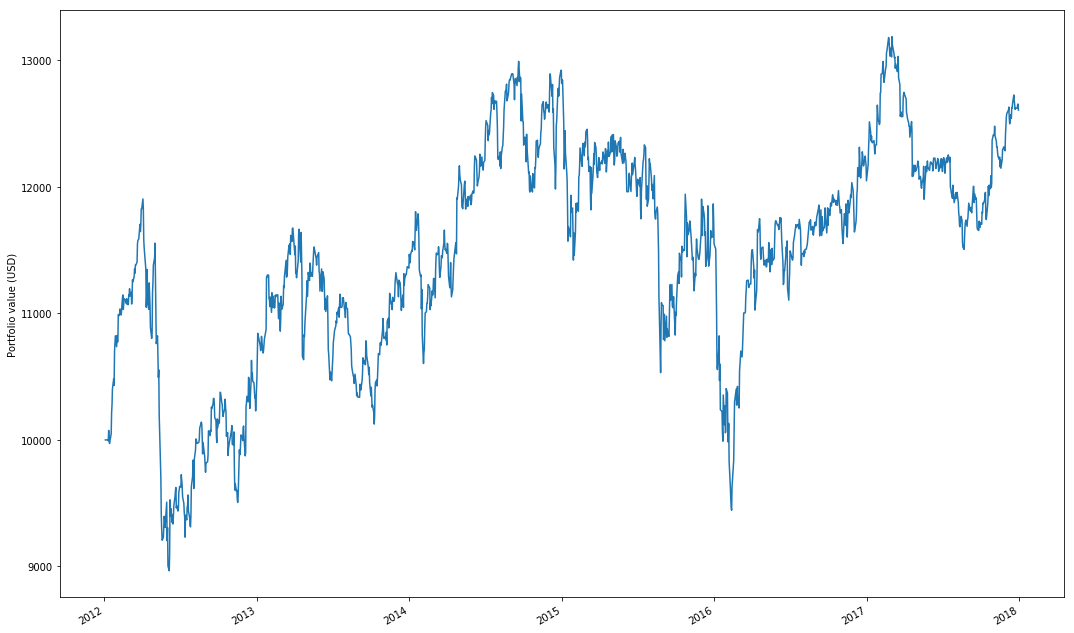

In [38]:
import matplotlib.pyplot as plt
# Set up the stuff for running the trading simulation
base_capital = 10000
start = datetime(2012, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2018, 1, 1, 0, 0, 0, 0, pytz.utc)
# run the trading algorithm and save the results in perf
perf = run_algorithm(start, end, initialize, base_capital, handle_data,
        bundle = 'quantopian-quandl', analyze=analyze)